In [1]:
!pip install pyarrow

In [2]:
import pandas as pd
import numpy as np
import warnings 
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow

In [3]:
warnings.filterwarnings('ignore')

# 1.1  Lectures des fichiers et merge 

In [4]:
df_customers = pd.read_csv('olist_customers_dataset.csv',  engine = 'python',  on_bad_lines = 'skip')
df_orders = pd.read_csv('olist_orders_dataset.csv',  engine = 'python',  on_bad_lines = 'skip')
df_orders_items = pd.read_csv('olist_order_items_dataset.csv',  engine = 'python',  on_bad_lines = 'skip')
df_reviews = pd.read_csv('olist_order_reviews_dataset.csv',  engine = 'python',  on_bad_lines = 'skip')
df_payments = pd.read_csv('olist_order_payments_dataset.csv',  engine = 'python',  on_bad_lines = 'skip')
df_geo = pd.read_csv('olist_geolocation_dataset.csv',  engine = 'python',  on_bad_lines = 'skip')
df_sellers = pd.read_csv('olist_sellers_dataset.csv',  engine = 'python',  on_bad_lines = 'skip')
df_products = pd.read_csv('olist_products_dataset.csv',  engine = 'python',  on_bad_lines = 'skip')
df_translate=  pd.read_csv('product_category_name_translation.csv',  engine = 'python',  on_bad_lines = 'skip')

In [5]:
df_customers['customer_id'].duplicated().sum()

0

In [6]:
df_customers['customer_unique_id'].duplicated().sum()

3345

In [7]:
df_merged = pd.merge(df_customers, df_orders[["order_id", "customer_id", "order_status","order_purchase_timestamp"]], on='customer_id')


In [8]:
df_merged.shape

(99441, 8)

In [9]:
#df_merged = pd.merge(df_merged, df_orders_items[["order_id", "order_item_id", "price", "product_id", "seller_id"]], on='order_id')
df_merged = pd.merge(df_merged, df_orders_items[["order_id", "price", "product_id", "seller_id"]], on='order_id')

In [10]:
df_merged.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'price', 'product_id', 'seller_id'],
      dtype='object')

In [11]:
df_merged = pd.merge(df_merged, df_reviews[["order_id", "review_id", "review_score", "review_creation_date"]], on='order_id')

In [12]:
df_merged = pd.merge(df_merged, df_products[["product_id", "product_category_name"]], on='product_id')

In [13]:
df_merged = pd.merge(df_merged, df_sellers[["seller_id", "seller_city"]], on='seller_id')

In [14]:
df_merged = pd.merge(df_merged, df_translate[["product_category_name", "product_category_name_english"]], on='product_category_name')

In [15]:
df_merged.shape

(110750, 17)

In [16]:
df_merged.describe()

,customer_zip_code_prefix,price,review_score
count,110750.000000,110750.000000,110750.000000
mean,35123.682257,120.475691,4.035395
std,29882.476174,181.861574,1.385325
min,1003.000000,0.850000,1.000000
25%,11310.000000,39.900000,4.000000
50%,24320.000000,74.900000,5.000000
75%,59054.000000,134.900000,5.000000
max,99980.000000,6735.000000,5.000000


In [17]:
df_merged.to_parquet("order_merges.parquet")    # préserve le format

In [18]:
df_merged.to_csv("order_merges.csv")

# 1.2  Nettoyage des individus
1) éliminer orders avec status canceled 
2) éliminer orders avec date d'achat manquante 
3) manquants, doublons, invalide, outliers

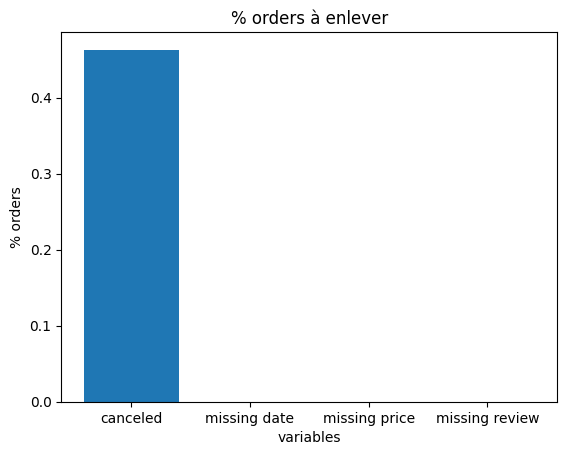

In [19]:
# Calculate the percentages
canceled_pct = 100*df_merged['order_status'].apply(lambda x: (x == 'canceled')).sum() / len(df_merged)
missing_date_pct = 100*df_merged['order_purchase_timestamp'].isnull().sum() / len(df_merged)
missing_price_pct = 100*df_merged['price'].isnull().sum() / len(df_merged)
missing_review_pct = 100*df_merged['review_score'].isnull().sum() / len(df_merged)

# Create the bar plot
values = [canceled_pct, missing_date_pct, missing_price_pct, missing_review_pct]
labels = ['canceled', 'missing date', 'missing price', 'missing review']
plt.bar(labels, values)

# Add labels and title
plt.xlabel('variables')
plt.ylabel('% orders')
plt.title('% orders à enlever')

plt.show()

In [20]:
data_1 = df_merged.drop(df_merged[df_merged['order_status'] == "canceled"].index)

In [21]:
data_1.shape

(110237, 17)

# 1.3  Nettoyage des variables 
1) customer info:  zip, state, customer_id (unique for each order)
2) colonnes used for merge:  product_id, seller_id, product_category_name, review_id, 

In [23]:
variable_remove = ['customer_state', 'customer_zip_code_prefix', 'customer_id', 'product_id', 'seller_id', \
                   'product_category_name', 'review_id', 'order_status', 'customer_city', 'order_id', 'review_creation_date', \
                  'seller_city', 'product_category_name_english']

In [24]:
data_2 = data_1.drop(columns = variable_remove)

In [25]:
data_2.shape

(110237, 4)

In [26]:
data_2.duplicated().sum()

11456

In [27]:
data_2.drop_duplicates(inplace=True)
data_2.dropna(inplace=True)

In [28]:
data_2.shape

(98781, 4)

In [29]:
data_2.to_csv("data.csv")

In [30]:
data_2['customer_unique_id'].duplicated().sum()

5786